# **IMPORTING LIBRARY**


In [1]:
!pip install pysastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 4.5 MB/s 


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


import nltk
from nltk import tokenize
from nltk.cluster.util import cosine_distance
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import gzip
import gensim
import logging
from gensim.models import Word2Vec

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **DATA LOADING**

In [4]:
# Loading dataset
data = pd.read_csv('https://raw.githubusercontent.com/H8-Assignments-Bay/p2---final-project-group-006/main/Dataset_final_project_grup6.csv')

In [5]:
data.head()

,No,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,Review
0,1,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,[('Fine Chocolate & Pattiserie ini tempatnya t...
1,2,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,[('Kopinya enak. Kental dan terasa kopinya. Ad...
2,3,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,[('Tempatnya mungil dengan nuansa berwarna bir...
3,4,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,[('mie yamin manis special enak sih lebih enak...
4,5,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,[('Kulitnya Enak Crispy Trs Dagingnya Juicy Bu...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No               120 non-null    int64  
 1   Nama Restaurant  120 non-null    object 
 2   Rating           120 non-null    float64
 3   Price            120 non-null    int64  
 4   Daerah           120 non-null    object 
 5   Tipe_1           120 non-null    object 
 6   Tipe_2           120 non-null    object 
 7   Tipe_3           120 non-null    object 
 8   Review           120 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 8.6+ KB


In [7]:
data.drop('No', axis=1, inplace=True)

# **EXPLORATORY DATA ANALYSIS**

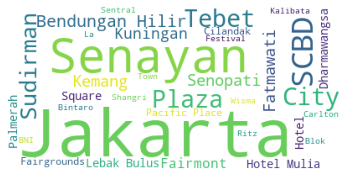

In [8]:
corpus = " ".join(data['Daerah'])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()

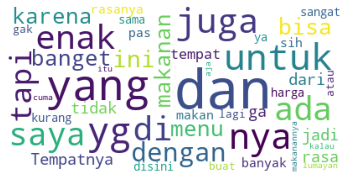

In [9]:
corpus = " ".join(data['Review'])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()

# **DATA PREPROCESSING**

In [10]:
lexicon = pd.read_csv('https://raw.githubusercontent.com/H8-Assignments-Bay/p2---final-project-group-006/main/Text%20Preprocessing/colloquial-indonesian-lexicon.csv')
formalize = pd.read_csv('https://raw.githubusercontent.com/H8-Assignments-Bay/p2---final-project-group-006/main/Text%20Preprocessing/formalize_word.csv')

In [11]:
lexicon

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0
...,...,...,...,...,...,...,...
15001,gataunya,tidak taunya,0,Ini kaya nenek2 ya beb gataunya agnezz @yugime...,akronim,0,0
15002,gtau,tidak tau,0,Stidaknya mrka may berkarya Dan berusaha yg tr...,akronim,abreviasi,0
15003,gatau,tidak tau,0,Ih gatau malu,akronim,0,0
15004,fans2,fan-fan,0,Jkt48 adalah tempat di mana sesama fans saling...,reduplikasi,naturalisasi,0


In [12]:
formalize

,Slang,Formal
0,bgs,bagus
1,jg,juga
2,Hy,hai
3,dlm,dalam
4,Mgkn,mungkin
5,krn,karena
6,hr,hari
7,dgn,dengan
8,utk,untuk
9,kek,seperti


In [13]:
# Melihat 10 data awal lexicon
dict_lexicon = pd.Series(lexicon.formal.values,index=lexicon.slang).to_dict()
dict_lexicon['brg'] = 'barang'
dict_lexicon['kw']='tiruan'
dict(list(dict_lexicon.items())[:10])

{'aminn': 'amin',
 'eeeehhhh': 'eh',
 'hallo': 'halo',
 'ka': 'kak',
 'kaka': 'kakak',
 'kata2nyaaa': 'kata-katanya',
 'keberpa': 'keberapa',
 'met': 'selamat',
 'netaas': 'menetas',
 'woww': 'wow'}

In [14]:
# Melihat 10 data awal
dict_formalize = pd.Series(formalize.Formal.values,index=formalize.Slang).to_dict()
dict(list(dict_formalize.items())[:10])

{'Hy': 'hai',
 'Mgkn': 'mungkin',
 'bgs': 'bagus',
 'dgn': 'dengan',
 'dlm': 'dalam',
 'hr': 'hari',
 'jg': 'juga',
 'kek': 'seperti',
 'krn': 'karena',
 'utk': 'untuk'}

In [15]:
def clean_text(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"    # emoticons
        u"\U0001F300-\U0001F5FF"    # symbols & pictographs
        u"\U0001F680-\U0001F6FF"    # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"    # flags (iOS)
        u"\U00002500-\U00002BEF"    # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"                   # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

    text = text.lower()                                                                                 # membuat huruf menjadi kecil
    text = re.sub(emoj, '', text)                                                                       # remove emoji
    text = re.sub(r'(.)\1{2,}', r'\1', text)                                                            # mengubah huruf berulang diatas 2 kali menjadi 1 saja
    text = re.sub("[0-9]", " ", text)                                                                   # remove numbers
    text = re.sub("(Diterjemahkan oleh Google)", " ", text)                                                                   
    text = re.sub("'s", " ", text) 
    text = re.sub("[¹²³¹⁰ⁱ⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ]", "", text)                                                     # remove power character
    text = re.sub("[^A-Za-z\s']"," ", text)  
    text = re.sub("[^\w\s]*[_,.!?#&;:><+-/)/(\'\"]", " ", text)                                         # remove bukan string dan whitespace
    text = ' '.join([re.sub(r'nya$|ny$', '', i) for i in text.split()])                                 # menghapus akhir kata 'nya' atau 'ny'
    text = " ".join(dict_lexicon[w] if w in dict_lexicon else w for w in text.split())                  # replace sesuai dict_lexicon
    text = " ".join(dict_formalize[w] if w in dict_formalize else w for w in text.split())              # replace sesuai dict_formalize
    text = re.sub(" +", " ", text.strip())                                                              # Remove unnecessary white space
    return text

def cleaner(data):
    data['text_preprocessed'] = data['Review'].apply(clean_text)
    return data

In [16]:
cleaner(data)
data.head()

,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,Review,text_preprocessed
0,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,[('Fine Chocolate & Pattiserie ini tempatnya t...,fine chocolate pattiserie ini tempat tidak ter...
1,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,[('Kopinya enak. Kental dan terasa kopinya. Ad...,kopi enak kental dan terasa kopi ada berbagai ...
2,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,[('Tempatnya mungil dengan nuansa berwarna bir...,tempat mungil dengan nuansa berwarna biru lucu...
3,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,[('mie yamin manis special enak sih lebih enak...,mie yamin manis special enak sih lebih enak ya...
4,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,[('Kulitnya Enak Crispy Trs Dagingnya Juicy Bu...,kulit enak crispy terus daging juicy bumbu mer...


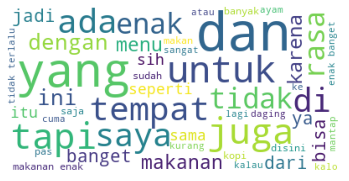

In [17]:
corpus = " ".join(data['text_preprocessed'])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()

In [18]:
for i in list(np.random.randint(0,len(data),1)):
    print('Original: ', data.iloc[i,7])
    print('Preprocessed: ', data.iloc[i,8])
    print('-'*50)

Original:  [('MORE 𝙁𝙤𝙤𝙙 & 𝘾𝙖𝙛𝙚 review,IG : @munchandsnap.jkt 𝟭/𝟰 𝗔𝘆𝗮𝗺 (𝗜𝗗𝗥 𝟮𝟱𝗸) Jadi ini tuh Roasted Chicken yang dikasih olesan saus Madu. Ukurannya besar, boleh request pilih dada/paha. Teksturnya super empuk sih!. 𝗡𝗮𝘀𝗶 (𝗜𝗗𝗥 𝟭𝟬-𝟭𝟱𝗸)Pilihannya ada 5: Nasi Putih, Biru, Kuning, Hainan dan JerukFavorit aku yang Nasi Jeruk, wangi banget trus ada potongan bawang putih goreng juga dimasak bareng nasinya gitu.🌶 𝗦𝗮𝗺𝗯𝗮𝗹 (𝗜𝗗𝗥 𝟮𝗸)
Sambal Mangga: yang ini okay, ada manis, sedikit pedas, seger dari mangganya Sambal Ijo: di antara semua ini yang paling pedes Sambal Matah: Salah satu Matah TERENAK! perpaduan isian sambelnya lengkap, wangi, pedes Sambal Tomat: cenderung manis aja, not my fav 𝗗𝗲𝘀𝘀𝗲𝗿𝘁 𝗶𝗻 𝗖𝘂𝗽 (𝗜𝗗𝗥 𝟮𝟬𝗸) Ada 2 varian: Classic Tiramisu & Fudge Chunky Brownies Tiramisunya quite good Chocolate sauce di Brownies enak, bold, slightly too sweet Perbandingan saus/creamnya lebih banyak dibanding sponge cakenya'); ('Penasaran karena food vlogger ngereview. Jadinya penasaran banget. Saya beli 3 eko

In [19]:
for i in list(np.random.randint(0,len(data),1)):
    print('Original: ', data.iloc[i,7])
    print('Preprocessed: ', data.iloc[i,8])
    print('-'*50)

Original:  [('Yang paling di suka disini itu kamar mandi nya Bagus gede juga dan ada musholla nya yang bersih dan nyaman banget. Untuk makanan dan minuman overall oke walau sedikit pricey menurut gue.
Kemarin pesen :
- nasi wagyu : ini enak sih ada bawang nya terus susu nya gtu pokoknya enak dan ngenyangin
- spaghetti aglio olio : ini juga enak aglio olio nya yang kering gitu cuma porsi nya gak terlalu banyak aja
- ice lychee tea : dikasih lychee nya dua biji
- ice lemon tea : rasanya rada hambar sih gak manis tapi gak asem juga'); ('Tempatnya agak masuk. Saya hanya mencoba espresso-nya dan overall enak.
Atmosfirnya nyaman dan tidak terlalu sibuk, lalu-lalang pelanggannya. Cocok untuk meeting kecil dan/atau kerja. Akan menjadi pilihan tempat kopi saya lain waktu kalau sedang berada di area Kemang.'); ('Nyaman karena ga rame walaupun di hari minggu dan akhir bulan. AC nya super dingin'); ('Coffee shop oke di kemang, tempatnya emang ga terlalu besar tapi tenang bgt buat wfh. Kalo mau kes

In [20]:
for i in range(1):
  print('Before :')
  print(data['Review'][i])
  print('---'*50)
  print('After :')
  print(data['text_preprocessed'][i])

Before :
[('Fine Chocolate & Pattiserie ini tempatnya tidak terlalu besar, interior yang terlihat elegan dan keren. Banyak sekali produk coklat yang dijual di sini mulai dari chocolate box, chocolate bar chocolate by the gram, ice cream, hot chocolate powder, minuman chocolate dan cakes dll. Cake di sini didisplay cantik, rasanya kepingin cobain semuanya deh. Ada area bar tersendiri untuk membuat minuman hot chocolate. Seating area terbatas, hanya ada 3 table saja. Tempat yang nyaman untuk menikmati dessert dan hot chocolate. Saya mencoba : *Java Hot 36% (55k++) - Ini adalah salah satu dari minuman single origin chocolate. Perpaduan milk dan cocoanya sangat pas dan ada hint hazelnutnya juga. Creamy, milky dan chocolatenya terasa rich, bitter sweetnya terasa pas dan mewah. Meskipun kadar coklatnya hanya 36% rasa coklatnya sudah terasa sekali. Minuman ini disajikan panas banget. Enak banget dan recommended.
 *Apple granny (55k++) - dessert ini tampil cute dengan bentuk seperti bola yang 

In [21]:
def stemmer_stopped(text):
    stemmer_factory = StemmerFactory()
    stemmer = stemmer_factory.create_stemmer()
    text = stemmer.stem(text)

    list_stopwords = set(stopwords.words('indonesian'))                             # stopword from nltk
    stopword_factory = StopWordRemoverFactory()                                     # stopword from sastrawi
    stopwords_sastrawi = set(stopword_factory.get_stop_words()) 
    list_stopwords = list_stopwords.union(stopwords_sastrawi)                       # join both stopword

    text = " ".join(w if w not in list_stopwords else '' for w in text.split())
    text = re.sub(" +", " ", text.strip())                                          # Remove unnecessary white space
    return text

def clean_stopword(data):
    data['clean stopword'] = data['text_preprocessed'].apply(stemmer_stopped)
    return data

In [22]:
clean_stopword(data)
data.head()

,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,Review,text_preprocessed,clean stopword
0,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,[('Fine Chocolate & Pattiserie ini tempatnya t...,fine chocolate pattiserie ini tempat tidak ter...,fine chocolate pattiserie interior elegan kere...
1,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,[('Kopinya enak. Kental dan terasa kopinya. Ad...,kopi enak kental dan terasa kopi ada berbagai ...,kopi kental asa kopi varian jenis kopi minum i...
2,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,[('Tempatnya mungil dengan nuansa berwarna bir...,tempat mungil dengan nuansa berwarna biru lucu...,mungil nuansa warna biru lucu nih wifi stop ko...
3,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,[('mie yamin manis special enak sih lebih enak...,mie yamin manis special enak sih lebih enak ya...,mie yamin manis special sih manis asin si pref...
4,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,[('Kulitnya Enak Crispy Trs Dagingnya Juicy Bu...,kulit enak crispy terus daging juicy bumbu mer...,kulit crispy daging juicy bumbu resap sambal p...


In [23]:
for i in range(1):
  print('Before :')
  print(data['Review'][i])
  print('---'*50)
  print('After :')
  print(data['text_preprocessed'][i])
  print('---'*50)
  print('After Clean Stopword :')
  print(data['clean stopword'][i])

Before :
[('Fine Chocolate & Pattiserie ini tempatnya tidak terlalu besar, interior yang terlihat elegan dan keren. Banyak sekali produk coklat yang dijual di sini mulai dari chocolate box, chocolate bar chocolate by the gram, ice cream, hot chocolate powder, minuman chocolate dan cakes dll. Cake di sini didisplay cantik, rasanya kepingin cobain semuanya deh. Ada area bar tersendiri untuk membuat minuman hot chocolate. Seating area terbatas, hanya ada 3 table saja. Tempat yang nyaman untuk menikmati dessert dan hot chocolate. Saya mencoba : *Java Hot 36% (55k++) - Ini adalah salah satu dari minuman single origin chocolate. Perpaduan milk dan cocoanya sangat pas dan ada hint hazelnutnya juga. Creamy, milky dan chocolatenya terasa rich, bitter sweetnya terasa pas dan mewah. Meskipun kadar coklatnya hanya 36% rasa coklatnya sudah terasa sekali. Minuman ini disajikan panas banget. Enak banget dan recommended.
 *Apple granny (55k++) - dessert ini tampil cute dengan bentuk seperti bola yang 

# **Do the recommendation system**

In [24]:
list(data['Nama Restaurant'].unique())

['KAKAW Fine Chocolate & Patisserie',
 'Join Kopi Bulungan',
 'Kopi Coga',
 'Mie Keriting Benhil "Mas Pujo"',
 'Rocky Rooster',
 'Kopi SSS',
 'Ayam Blenger PSP',
 'Dimsum Pertok',
 'Rumah Makan Surya',
 'Mie Ayam Gamat',
 'Sate Taichan 87 Bang Ocit',
 'Nasi Peda Pelangi',
 'Mie Aceh Jaly - Jaly',
 'Setengah Lima Coffee',
 'Chickro',
 'Soto Mie Teh Ussy',
 'Gudeg Pejompongan',
 'HABITUAL COFFEE & EATERY (Roti Bakar Kemang)',
 'Warung Steak 76',
 'Kedai Halaman',
 'HAOTE - Sate Maranggi',
 'Amyrea Art & Kitchen',
 'Mangkok Ku',
 'Sari Ratu',
 'Soto Kudus Senayan',
 'Bopet Mini',
 'Obonk Steak & Ribs',
 'Ben & Bill',
 'First Scoop',
 'Warung Fotkop',
 'Hokkaido Baked Cheese Tart',
 'Blumchen Coffee',
 'Bu Eva Spesial Sambal',
 'Nitro Coffee',
 'Louie Coffee',
 'Koko Bogana',
 'Coffite - Quality Street Coffee',
 'MASALALU',
 'Mie Ceker Bandung',
 'Kambing Babeh Dolof',
 'House Of Sore',
 'Saung Rasa',
 'CoPaste (Coffee Pasar Tebet)',
 'Bunna Coffee',
 'Bakmi Kusuma',
 'Gokana Ramen & Teppa

In [25]:
nama_restaurant = list(data['Nama Restaurant'].unique())

In [26]:
def get_top_words (max_topwords) :
  top_words = []
  for ix in range(len(data)) :
    count_vec = CountVectorizer()
    matrix = count_vec.fit_transform([data['clean stopword'][ix]])
    counts = pd.DataFrame(matrix.toarray(),columns=count_vec.get_feature_names())
    top=counts.T.sort_values(by=0, ascending=False).head(max_topwords)
    index_top=top.index.tolist()
    join_kolom=" ".join(index_top)
    top_words.append(join_kolom)

  data["kata_top"] = top_words
  return data

In [27]:
get_top_words (max_topwords=30).head(5)

,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,Review,text_preprocessed,clean stopword,kata_top
0,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,[('Fine Chocolate & Pattiserie ini tempatnya t...,fine chocolate pattiserie ini tempat tidak ter...,fine chocolate pattiserie interior elegan kere...,kue chocolate cokelat coba minum cake coklat k...
1,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,[('Kopinya enak. Kental dan terasa kopinya. Ad...,kopi enak kental dan terasa kopi ada berbagai ...,kopi kental asa kopi varian jenis kopi minum i...,kopi duduk harga ramai malam gor bulungan park...
2,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,[('Tempatnya mungil dengan nuansa berwarna bir...,tempat mungil dengan nuansa berwarna biru lucu...,mungil nuansa warna biru lucu nih wifi stop ko...,kopi nyaman coga susu pas lumayan hilir bendun...
3,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,[('mie yamin manis special enak sih lebih enak...,mie yamin manis special enak sih lebih enak ya...,mie yamin manis special sih manis asin si pref...,mie ayam makan manis porsi benhil coba yamin s...
4,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,[('Kulitnya Enak Crispy Trs Dagingnya Juicy Bu...,kulit enak crispy terus daging juicy bumbu mer...,kulit crispy daging juicy bumbu resap sambal p...,ayam makan harga sambal saos nyaman jangkau uk...


In [28]:
data_con_kata_top = get_top_words (max_topwords=10)

In [29]:
data_new=data_con_kata_top.drop(['Review'],axis=1)
# df_percent = data_new.sample(frac=1)
df_percent = data_new

In [30]:
df_percent.head()

,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,text_preprocessed,clean stopword,kata_top
0,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,fine chocolate pattiserie ini tempat tidak ter...,fine chocolate pattiserie interior elegan kere...,kue chocolate cokelat coba minum cake coklat k...
1,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,kopi enak kental dan terasa kopi ada berbagai ...,kopi kental asa kopi varian jenis kopi minum i...,kopi duduk harga ramai malam gor bulungan park...
2,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,tempat mungil dengan nuansa berwarna biru lucu...,mungil nuansa warna biru lucu nih wifi stop ko...,kopi nyaman coga susu pas lumayan hilir bendun...
3,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,mie yamin manis special enak sih lebih enak ya...,mie yamin manis special sih manis asin si pref...,mie ayam makan manis porsi benhil coba yamin s...
4,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,kulit enak crispy terus daging juicy bumbu mer...,kulit crispy daging juicy bumbu resap sambal p...,ayam makan harga sambal saos nyaman jangkau uk...


In [31]:
len(df_percent)

120

In [32]:
df_percent.keys()

Index(['Nama Restaurant', 'Rating', 'Price', 'Daerah', 'Tipe_1', 'Tipe_2',
       'Tipe_3', 'text_preprocessed', 'clean stopword', 'kata_top'],
      dtype='object')

In [33]:
df_percent.set_index('Nama Restaurant', inplace=True)
indices = pd.Series(df_percent.index)

# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0)
tfidf_matrix = tfidf.fit_transform(df_percent['kata_top'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [34]:
print(tfidf_matrix.shape)

(120, 1227)


In [35]:
cosine_similarities_coba = linear_kernel(tfidf_matrix, tfidf_matrix[1])

In [36]:
len(cosine_similarities_coba)

120

In [37]:
df_percent.head()

,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,text_preprocessed,clean stopword,kata_top
Nama Restaurant,,,,,,,,,
KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,fine chocolate pattiserie ini tempat tidak ter...,fine chocolate pattiserie interior elegan kere...,kue chocolate cokelat coba minum cake coklat k...
Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,kopi enak kental dan terasa kopi ada berbagai ...,kopi kental asa kopi varian jenis kopi minum i...,kopi duduk harga ramai malam gor bulungan park...
Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,tempat mungil dengan nuansa berwarna biru lucu...,mungil nuansa warna biru lucu nih wifi stop ko...,kopi nyaman coga susu pas lumayan hilir bendun...
"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,mie yamin manis special enak sih lebih enak ya...,mie yamin manis special sih manis asin si pref...,mie ayam makan manis porsi benhil coba yamin s...
Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,kulit enak crispy terus daging juicy bumbu mer...,kulit crispy daging juicy bumbu resap sambal p...,ayam makan harga sambal saos nyaman jangkau uk...


In [38]:
cosine_similarities

array([[1.        , 0.00596775, 0.        , ..., 0.0065829 , 0.        ,
        0.01307944],
       [0.00596775, 1.        , 0.0204831 , ..., 0.        , 0.        ,
        0.00635844],
       [0.        , 0.0204831 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0065829 , 0.        , 0.        , ..., 1.        , 0.04840393,
        0.11727635],
       [0.        , 0.        , 0.        , ..., 0.04840393, 1.        ,
        0.00339635],
       [0.01307944, 0.00635844, 0.        , ..., 0.11727635, 0.00339635,
        1.        ]])

In [39]:
cosine_similarities.shape

(120, 120)

In [40]:
df_percent.keys()

Index(['Rating', 'Price', 'Daerah', 'Tipe_1', 'Tipe_2', 'Tipe_3',
       'text_preprocessed', 'clean stopword', 'kata_top'],
      dtype='object')

In [41]:
def recommend(name, cosine_similarities = cosine_similarities):
    
    # Create a list to put top restaurants
    recommend_restaurant = []
    
    # Find the index of the restaurant entered
    idx = indices[indices == name].index[0]
    
    # Find the restaurants with a similar cosine-sim value and order them from biggest number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    dat_for_filter = pd.DataFrame(columns=['Rating', 'Price', 'Daerah','Tipe_1', 'Tipe_2', 'Tipe_3'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        dat_for_filter = dat_for_filter.append(pd.DataFrame(df_percent[['Rating', 'Price', 'Daerah','Tipe_1', 'Tipe_2', 'Tipe_3']][df_percent.index == each].sample()))
    
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    dat_for_filter = dat_for_filter.drop_duplicates(subset=['Rating', 'Price', 'Daerah','Tipe_1', 'Tipe_2', 'Tipe_3'], keep=False)
    dat_for_filter = dat_for_filter.head(6)
    
    print('TOP %s TEMPAT MAKAN/RESTORAN YANG MEMILIKI REVIEW MIRIP %s : ' % (str(len(dat_for_filter)-1), name))
    
    return dat_for_filter[1:]



In [42]:
recommend('KAKAW Fine Chocolate & Patisserie')

TOP 5 TEMPAT MAKAN/RESTORAN YANG MEMILIKI REVIEW MIRIP KAKAW Fine Chocolate & Patisserie : 


,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3
Amyrea Art & Kitchen,3.0,40000,"Senayan, Jakarta",Indonesia,-,-
Colette & Lola,4.5,105000,"Senopati, Jakarta",Desserts,Itali,Barat
LEMONDISCOFISH,4.2,75000,"Kemang, Jakarta",Kopi,Desserts,Ice Cream
Hokkaido Baked Cheese Tart,4.3,50000,"Senayan City, Senayan, Jakarta",Desserts,Jepang,-
Kopi SSS,3.7,25000,"Sudirman, Jakarta",Kopi,Minuman,-


In [43]:
result = recommend('KAKAW Fine Chocolate & Patisserie')

TOP 5 TEMPAT MAKAN/RESTORAN YANG MEMILIKI REVIEW MIRIP KAKAW Fine Chocolate & Patisserie : 


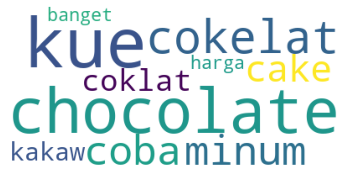

In [44]:
corpus = " ".join(data_con_kata_top[data_con_kata_top["Nama Restaurant"] == "KAKAW Fine Chocolate & Patisserie"]["kata_top"])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()

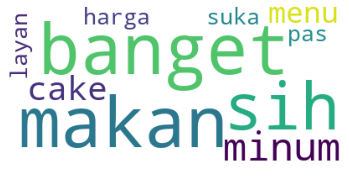

In [45]:
corpus = " ".join(data_con_kata_top[data_con_kata_top["Nama Restaurant"] == "Amyrea Art & Kitchen"]["kata_top"])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()